<a href="https://colab.research.google.com/github/Vnshita/diabetes-streamlit-app/blob/main/diabetesPredEnsembleLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 0) Install dependencies (run once)
!pip install -q scikit-learn pandas matplotlib seaborn joblib xgboost lightgbm streamlit

# 1) Imports
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import joblib

# xgboost & lightgbm (installed above)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 105.4 MB/s eta 0:00:00


In [3]:
# -------------------------------
# 2) Load dataset and augment with extra fields for training
# -------------------------------
print("Loading dataset...")
url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)
print("Original dataset shape:", df.shape)

# Add realistic extra fields so models can learn from them:
# - PulseRate (random reasonable values)
# - SkinColor (categorical mapped later)
# - Vision (categorical mapped later)
# - Medical history flags: Hypertension, Obesity, FamilyHistory (synthetic)
rng = np.random.default_rng(42)
df["PulseRate"] = rng.integers(60, 100, size=len(df))
# map skin color categories randomly: 'Fair','Medium','Dark'
df["SkinColorCat"] = rng.choice(["Fair","Medium","Dark"], size=len(df))
# vision categories
df["VisionCat"] = rng.choice(["Normal","Blurred","Impaired"], size=len(df))
# synthetic medical-history flags (0/1)
df["Hypertension"] = rng.choice([0,1], size=len(df), p=[0.8,0.2])
df["ObesityFlag"] = (df["BMI"] > 30).astype(int)  # use BMI as proxy
df["FamilyHistory"] = rng.choice([0,1], size=len(df), p=[0.85,0.15])

print("Augmented dataset shape:", df.shape)
display(df.head())

Loading dataset...
Original dataset shape: (768, 9)
Augmented dataset shape: (768, 15)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,PulseRate,SkinColorCat,VisionCat,Hypertension,ObesityFlag,FamilyHistory
0,6,148,72,35,0,33.6,0.627,50,1,63,Fair,Normal,0,1,0
1,1,85,66,29,0,26.6,0.351,31,0,90,Medium,Normal,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,86,Medium,Impaired,0,0,0
3,1,89,66,23,94,28.1,0.167,21,0,77,Dark,Blurred,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,77,Fair,Blurred,0,1,0


In [4]:
# -------------------------------
# 3) Encode categorical columns
# -------------------------------
le_skin = LabelEncoder()
le_vision = LabelEncoder()
df["SkinColor"] = le_skin.fit_transform(df["SkinColorCat"])
df["Vision"] = le_vision.fit_transform(df["VisionCat"])

# Choose features for model training:
feature_cols = [
    "Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
    "BMI","DiabetesPedigreeFunction","Age",
    "PulseRate","SkinColor","Vision",
    "Hypertension","ObesityFlag","FamilyHistory"
]
X = df[feature_cols].copy()
y = df["Outcome"].copy()

# Save encoder info (for later use)
encoders = {"le_skin": le_skin, "le_vision": le_vision}


In [5]:
# -------------------------------
# 4) Train-test split & scaling
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
# -------------------------------
# 5) Define models
# -------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_estimators=200),
    "LightGBM": LGBMClassifier(random_state=42, n_estimators=200)
}

# Add a Voting classifier (soft)
voting = VotingClassifier(
    estimators=[(name, mdl) for name, mdl in models.items() if name!="Voting"],
    voting="soft"
)
models["Voting"] = voting

In [7]:
# -------------------------------
# 6) Train models
# -------------------------------
print("\nTraining models (this may take a few minutes)...")
for name, mdl in models.items():
    # For LogisticRegression use scaled data; for tree-based models scaling isn't necessary but works fine
    if name == "Logistic Regression":
        mdl.fit(X_train_scaled, y_train)
    else:
        mdl.fit(X_train, y_train)
    print(f" Trained: {name}")


Training models (this may take a few minutes)...
 Trained: Logistic Regression
 Trained: Random Forest
 Trained: Gradient Boosting
 Trained: XGBoost
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


=== Logistic Regression ===
Accuracy: 0.7272727272727273
Confusion Matrix:
 [[83 17]
 [25 29]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       0.63      0.54      0.58        54

    accuracy                           0.73       154
   macro avg       0.70      0.68      0.69       154
weighted avg       0.72      0.73      0.72       154


=== Random Forest ===
Accuracy: 0.7597402597402597
Confusion Matrix:
 [[84 16]
 [21 33]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       100
           1       0.67      0.61      0.64        54

    accuracy                           0.76       154
   macro avg       0.74      0.73      0.73       154
weighted avg       0.76      0.76      0.76       154


=== Gradient Boosting ===
Accuracy: 0.7532467532467533
Confusion Matrix:
 [[81 19]
 [19 35]]
              precision    recall  f1-score   support

           

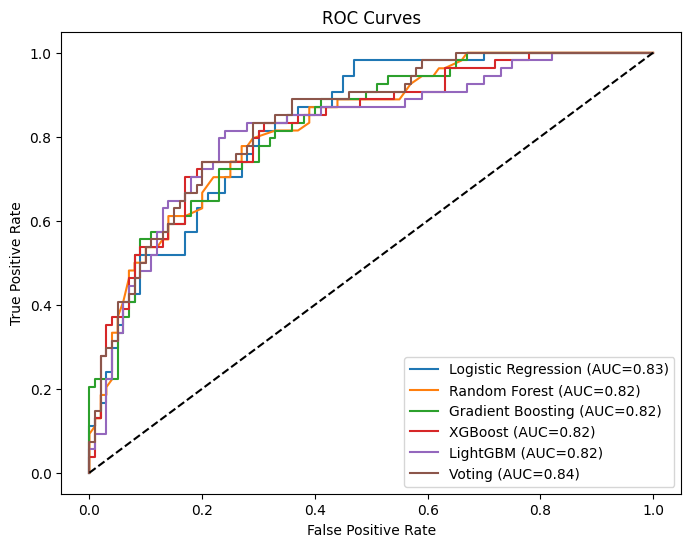

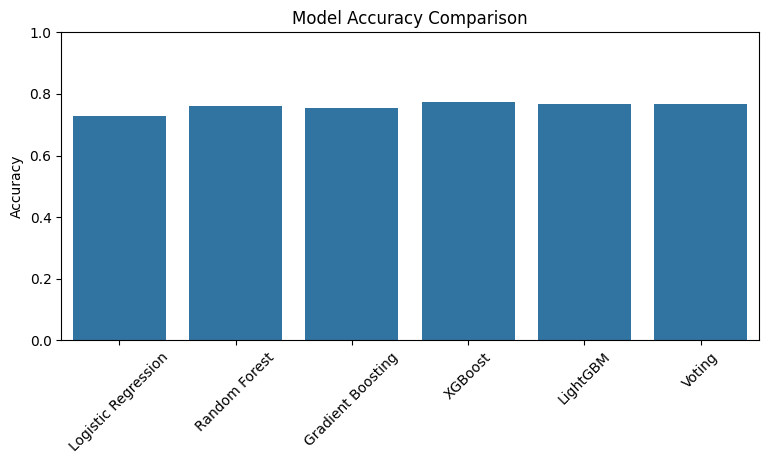

In [8]:
# -------------------------------
# 7) Evaluate models: accuracy, confusion matrix, ROC
# -------------------------------
metrics = {}
plt.figure(figsize=(8,6))
for name, mdl in models.items():
    if name == "Logistic Regression":
        y_proba = mdl.predict_proba(X_test_scaled)[:,1]
        y_pred = mdl.predict(X_test_scaled)
    else:
        y_proba = mdl.predict_proba(X_test)[:,1]
        y_pred = mdl.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    metrics[name] = {"accuracy": acc, "y_pred": y_pred, "y_proba": y_proba}
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_score:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Accuracy comparison bar chart
plt.figure(figsize=(9,4))
names = list(metrics.keys())
accs = [metrics[n]["accuracy"] for n in names]
sns.barplot(x=names, y=accs)
plt.xticks(rotation=45)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()

In [9]:
# -------------------------------
# 8) Save models, scaler and encoders for Streamlit deployment
# -------------------------------
print("\nSaving models and preprocessor objects...")
joblib.dump(scaler, "scaler.pkl")
for name, mdl in models.items():
    safe_name = name.replace(" ", "_").lower()
    joblib.dump(mdl, f"{safe_name}.pkl")
# save encoders
joblib.dump(encoders, "encoders.pkl")
print("Saved: scaler.pkl, encoders.pkl and model .pkl files (one per model).")


Saving models and preprocessor objects...
Saved: scaler.pkl, encoders.pkl and model .pkl files (one per model).


In [10]:
# -------------------------------
# 9) Show sample input format and examples
# -------------------------------
print("\n\n===== INPUT FORMAT (sample) =====")
print("You will be asked to provide the following fields for each patient.")
sample = {
    "Name": "John Doe",
    "Height_cm": 170,
    "Medical_History": "Hypertension, family_diabetes",
    "Pregnancies": 2,
    "Glucose": 120,
    "BloodPressure": 80,
    "SkinThickness": 25,
    "Insulin": 85,
    "BMI": 28.5,
    "DiabetesPedigreeFunction": 0.5,
    "Age": 45,
    "PulseRate": 78,
    "SkinColor": "Medium",   # allowed values: Fair / Medium / Dark
    "Vision": "Normal"       # allowed values: Normal / Blurred / Impaired
}
display(pd.DataFrame([sample]))

print("You can enter multiple patients interactively (you'll be prompted).")



===== INPUT FORMAT (sample) =====
You will be asked to provide the following fields for each patient.


,Name,Height_cm,Medical_History,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,PulseRate,SkinColor,Vision
0,John Doe,170,"Hypertension, family_diabetes",2,120,80,25,85,28.5,0.5,45,78,Medium,Normal


You can enter multiple patients interactively (you'll be prompted).


In [11]:
# -------------------------------
# 10) Helper: parse medical history text into flags
# -------------------------------
def parse_history_flags(history_text):
    text = str(history_text).lower()
    return {
        "Hypertension": int("hypert" in text or "blood pressure" in text),
        "ObesityFlag": int("obes" in text or "obesity" in text or "overweight" in text),
        "FamilyHistory": int("family" in text and ("diabet" in text or "diabetes" in text)) or int("diabet" in text and "family" in text)
    }


Enter patient details. After each patient you'll be asked whether to add another.

Patient Name: vanshiuyta
Height (cm): 123
Medical History (comma separated free text): 12
Pregnancies (e.g., 2): 2
Glucose (mg/dL, e.g., 120): 2
BloodPressure (mmHg, e.g., 80): 223
SkinThickness (mm, e.g., 25): 22
Insulin (mu U/ml, e.g., 85): 223
BMI (kg/m2, e.g., 28.5): 22
DiabetesPedigreeFunction (e.g., 0.5): 22
Age (years, e.g., 45): 1222
Pulse Rate (bpm, e.g., 78): 22
Skin Color (Fair / Medium / Dark): 222
Vision (Normal / Blurred / Impaired): normal
Add another patient? (y/n): n


,Name,Height_cm,Medical_History
0,vanshiuyta,123.0,12


,PatientIndex,Name,Model,Prediction,Prob_Diabetic
0,1,vanshiuyta,Logistic Regression,Diabetic,1.000000
1,1,vanshiuyta,Random Forest,Non-Diabetic,0.280000
2,1,vanshiuyta,Gradient Boosting,Non-Diabetic,0.012611
3,1,vanshiuyta,XGBoost,Non-Diabetic,0.030681
4,1,vanshiuyta,LightGBM,Non-Diabetic,0.000147
5,1,vanshiuyta,Voting,Non-Diabetic,0.264688


,Model,Gradient Boosting,LightGBM,Logistic Regression,Random Forest,Voting,XGBoost
PatientIndex,Name,,,,,,
1,vanshiuyta,0.012611,0.000147,1.0,0.28,0.264688,0.030681



Patient 1 — vanshiuyta


,Model,Prediction,Prob_Diabetic
0,Logistic Regression,Diabetic,1.000000
1,Random Forest,Non-Diabetic,0.280000
2,Gradient Boosting,Non-Diabetic,0.012611
3,XGBoost,Non-Diabetic,0.030681
4,LightGBM,Non-Diabetic,0.000147
5,Voting,Non-Diabetic,0.264688


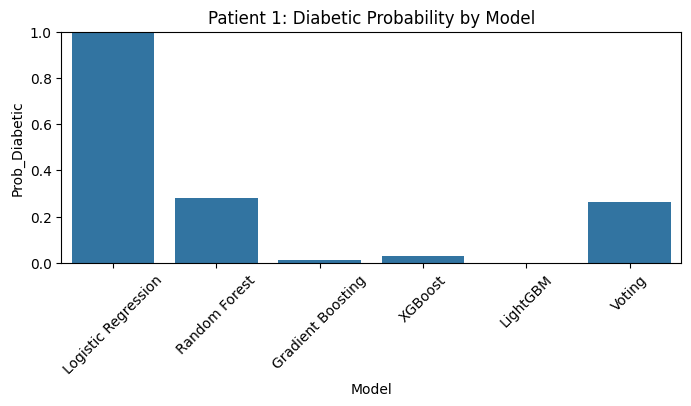

 Majority vote: Non-Diabetic (1/6 models voted Diabetic)
 Average probability: 0.265 -> Non-Diabetic

Saved predictions to predictions_all_models.csv - download it from runtime files if needed.

All done ✅


In [12]:
# -------------------------------
# 11) Interactive input loop for multiple patients
# -------------------------------
def interact_and_predict():
    patients = []
    print("\nEnter patient details. After each patient you'll be asked whether to add another.\n")
    while True:
        name = input("Patient Name: ").strip()
        height = float(input("Height (cm): "))
        history = input("Medical History (comma separated free text): ").strip()
        # diabetes features
        preg = float(input("Pregnancies (e.g., 2): "))
        glu = float(input("Glucose (mg/dL, e.g., 120): "))
        bp = float(input("BloodPressure (mmHg, e.g., 80): "))
        st = float(input("SkinThickness (mm, e.g., 25): "))
        ins = float(input("Insulin (mu U/ml, e.g., 85): "))
        bmi = float(input("BMI (kg/m2, e.g., 28.5): "))
        dpf = float(input("DiabetesPedigreeFunction (e.g., 0.5): "))
        age = int(input("Age (years, e.g., 45): "))
        pulse = int(input("Pulse Rate (bpm, e.g., 78): "))

        # SkinColor input (map to encoder)
        skin_in = input("Skin Color (Fair / Medium / Dark): ").strip().capitalize()
        if skin_in not in le_skin.classes_:
            print(f"Warning: '{skin_in}' not in known categories. Using 'Medium'.")
            skin_in = "Medium"
        skin_enc = le_skin.transform([skin_in])[0]

        # Vision input
        vision_in = input("Vision (Normal / Blurred / Impaired): ").strip().capitalize()
        if vision_in not in le_vision.classes_:
            print(f"Warning: '{vision_in}' not in known categories. Using 'Normal'.")
            vision_in = "Normal"
        vision_enc = le_vision.transform([vision_in])[0]

        # Parse history flags (if user provided explicit flags, prefer those)
        flags = parse_history_flags(history)
        # If user typed explicit words, use that; else keep flags as above

        # assemble model-features row
        row = {
            "Name": name,
            "Height_cm": height,
            "Medical_History": history,
            "Pregnancies": preg,
            "Glucose": glu,
            "BloodPressure": bp,
            "SkinThickness": st,
            "Insulin": ins,
            "BMI": bmi,
            "DiabetesPedigreeFunction": dpf,
            "Age": age,
            "PulseRate": pulse,
            "SkinColor": skin_enc,
            "Vision": vision_enc,
            "Hypertension": flags["Hypertension"],
            "ObesityFlag": flags["ObesityFlag"],
            "FamilyHistory": flags["FamilyHistory"]
        }
        patients.append(row)
        cont = input("Add another patient? (y/n): ").strip().lower()
        if cont != "y":
            break

    # Build DataFrame and run predictions
    patients_df = pd.DataFrame(patients)
    display(patients_df[["Name","Height_cm","Medical_History"]].head())

    # Prepare features for models
    model_X = patients_df[feature_cols].copy()
    # scale for logistic regression; tree models use raw features but scaling is OK
    model_X_scaled = scaler.transform(model_X)

    # Collect predictions & probabilities per model (long format)
    long_results = []
    for mdl_name, mdl in models.items():
        if mdl_name == "Logistic Regression":
            probs = mdl.predict_proba(model_X_scaled)[:,1]
            preds = mdl.predict(model_X_scaled)
        else:
            probs = mdl.predict_proba(model_X)[:,1]
            preds = mdl.predict(model_X)
        for i in range(len(patients_df)):
            long_results.append({
                "PatientIndex": i+1,
                "Name": patients_df.loc[i,"Name"],
                "Model": mdl_name,
                "Prediction": "Diabetic" if preds[i]==1 else "Non-Diabetic",
                "Prob_Diabetic": float(probs[i])
            })

    results_long_df = pd.DataFrame(long_results)
    display(results_long_df.head(20))

    # Pivot: patients x models (Prob_Diabetic)
    pivot = results_long_df.pivot_table(index=["PatientIndex","Name"], columns="Model", values="Prob_Diabetic")
    display(pivot)

    # For each patient show a neat table of all model predictions and probabilities
    for i in range(len(patients_df)):
        print("\n" + "="*60)
        print(f"Patient {i+1} — {patients_df.loc[i,'Name']}")
        subset = results_long_df[results_long_df["PatientIndex"]==i+1].copy()
        subset = subset[["Model","Prediction","Prob_Diabetic"]].reset_index(drop=True)
        display(subset)

        # Bar chart of Prob_Diabetic by model for this patient
        plt.figure(figsize=(8,3))
        sns.barplot(x="Model", y="Prob_Diabetic", data=subset)
        plt.ylim(0,1)
        plt.title(f"Patient {i+1}: Diabetic Probability by Model")
        plt.xticks(rotation=45)
        plt.show()

        # Final aggregated decisions:
        # 1) majority vote across models' binary predictions
        votes = (subset["Prediction"] == "Diabetic").astype(int).sum()
        majority_vote = "Diabetic" if votes > (len(subset)/2) else "Non-Diabetic"

         # 2) average probability across models
        avg_prob = subset["Prob_Diabetic"].mean()
        avg_decision = "Diabetic" if avg_prob >= 0.5 else "Non-Diabetic"

        print(f" Majority vote: {majority_vote} ({votes}/{len(subset)} models voted Diabetic)")
        print(f" Average probability: {avg_prob:.3f} -> {avg_decision}")

    # offer CSV download of results
    out_df = results_long_df.copy()
    out_df.to_csv("predictions_all_models.csv", index=False)
    print("\nSaved predictions to predictions_all_models.csv - download it from runtime files if needed.")
    return patients_df, results_long_df, pivot

# Run interactive prompt:
patients_df, results_long_df, pivot = interact_and_predict()
print("\nAll done ✅")

In [ ]:
!pip install -q streamlit pyngrok scikit-learn pandas matplotlib seaborn joblib xgboost lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 106.6 MB/s eta 0:00:00


In [13]:
import os

# Create main folder
project_folder = "diabetes-streamlit-app"
os.makedirs(project_folder, exist_ok=True)

# Create models folder
os.makedirs(f"{project_folder}/models", exist_ok=True)

print("Folder structure created ✅")

Folder structure created ✅


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Logistic Regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, random_state=42)
gb_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42, n_estimators=200)
xgb_model.fit(X_train, y_train)

# LightGBM
lgbm_model = LGBMClassifier(random_state=42, n_estimators=200)
lgbm_model.fit(X_train, y_train)

# Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ("Logistic", logistic_model),
        ("RF", rf_model),
        ("GB", gb_model),
        ("XGB", xgb_model),
        ("LGBM", lgbm_model)
    ],
    voting="soft"
)
voting_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 717
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

VotingClassifier(estimators=[('Logistic', LogisticRegression(max_iter=1000)),
                             ('RF',
                              RandomForestClassifier(n_estimators=200,
                                                     random_state=42)),
                             ('GB',
                              GradientBoostingClassifier(n_estimators=200,
                                                         random_state=42)),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=Non...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('LGBM',
                              LGBMClassifier(n_estimators=200,
                                             random_state=42))],
                 voting='soft')

In [15]:
import joblib

# Example: save all models to models folder
joblib.dump(logistic_model, f"{project_folder}/models/logistic_regression.pkl")
joblib.dump(rf_model, f"{project_folder}/models/random_forest.pkl")
joblib.dump(gb_model, f"{project_folder}/models/gradient_boosting.pkl")
joblib.dump(xgb_model, f"{project_folder}/models/xgboost.pkl")
joblib.dump(lgbm_model, f"{project_folder}/models/lightgbm.pkl")
joblib.dump(voting_model, f"{project_folder}/models/voting.pkl")
joblib.dump(scaler, f"{project_folder}/models/scaler.pkl")
joblib.dump(encoders, f"{project_folder}/models/encoders.pkl")

print("Models saved ✅")

Models saved ✅


In [16]:
utils_code = """
import joblib
import pandas as pd

def load_models():
    import os
    model_files = [f for f in os.listdir("models") if f.endswith(".pkl") and "encoders" not in f and "scaler" not in f]
    models = {f.replace(".pkl",""): joblib.load(f"models/{f}") for f in model_files}
    scaler = joblib.load("models/scaler.pkl")
    encoders = joblib.load("models/encoders.pkl")
    return models, scaler, encoders

def encode_inputs(skin, vision, encoders):
    le_skin = encoders["le_skin"]
    le_vision = encoders["le_vision"]
    if skin not in le_skin.classes_:
        skin = "Medium"
    if vision not in le_vision.classes_:
        vision = "Normal"
    return le_skin.transform([skin])[0], le_vision.transform([vision])[0]

def parse_history_flags(history_text):
    text = str(history_text).lower()
    return {
        "Hypertension": int("hypert" in text or "blood pressure" in text),
        "ObesityFlag": int("obes" in text or "obesity" in text or "overweight" in text),
        "FamilyHistory": int("family" in text and ("diabet" in text or "diabetes" in text)) or int("diabet" in text and "family" in text)
    }

def predict_patient(df, models, scaler):
    feature_cols = [
        "Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
        "BMI","DiabetesPedigreeFunction","Age",
        "PulseRate","SkinColor","Vision",
        "Hypertension","ObesityFlag","FamilyHistory"
    ]
    X = df[feature_cols].copy()
    X_scaled = scaler.transform(X)
    results = []
    for name, mdl in models.items():
        if name.lower()=="logistic_regression":
            y_proba = mdl.predict_proba(X_scaled)[:,1]
            y_pred = mdl.predict(X_scaled)
        else:
            y_proba = mdl.predict_proba(X)[:,1]
            y_pred = mdl.predict(X)
        results.append((name, y_pred, y_proba))
    return results
"""

with open(f"{project_folder}/utils.py","w") as f:
    f.write(utils_code)

print("utils.py created ✅")

utils.py created ✅


In [18]:
app_code = """
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import load_models, encode_inputs, parse_history_flags, predict_patient

st.set_page_config(page_title="Diabetes Prediction App", layout="wide")
st.title("💉 Diabetes Prediction App")

# Load models
models, scaler, encoders = load_models()

# Sidebar for patient input
st.sidebar.header("Patient Details Input")
num_patients = st.sidebar.number_input("Number of Patients", min_value=1, max_value=10, value=1)

patient_data = []
for i in range(num_patients):
    st.sidebar.subheader(f"Patient {i+1}")
    name = st.sidebar.text_input(f"Name {i+1}", f"Patient {i+1}")
    preg = st.sidebar.number_input(f"Pregnancies {i+1}", 0, 20, 2)
    glu = st.sidebar.number_input(f"Glucose {i+1}", 50, 300, 120)
    bp = st.sidebar.number_input(f"BloodPressure {i+1}", 50, 200, 80)
    st_skin = st.sidebar.number_input(f"SkinThickness {i+1}", 5, 100, 25)
    ins = st.sidebar.number_input(f"Insulin {i+1}", 0, 1000, 85)
    bmi = st.sidebar.number_input(f"BMI {i+1}", 10.0, 60.0, 28.5)
    dpf = st.sidebar.number_input(f"DPF {i+1}", 0.0, 2.5, 0.5)
    age = st.sidebar.number_input(f"Age {i+1}", 1, 120, 45)
    pulse = st.sidebar.number_input(f"PulseRate {i+1}", 40, 200, 78)
    skin_color = st.sidebar.selectbox(f"Skin Color {i+1}", ["Fair","Medium","Dark"])
    vision = st.sidebar.selectbox(f"Vision {i+1}", ["Normal","Blurred","Impaired"])
    history = st.sidebar.text_input(f"Medical History {i+1}", "Hypertension, family_diabetes")

    skin_enc, vision_enc = encode_inputs(skin_color, vision, encoders)
    flags = parse_history_flags(history)

    patient_data.append({
        "Name": name,
        "Pregnancies": preg,
        "Glucose": glu,
        "BloodPressure": bp,
        "SkinThickness": st_skin,
        "Insulin": ins,
        "BMI": bmi,
        "DiabetesPedigreeFunction": dpf,
        "Age": age,
        "PulseRate": pulse,
        "SkinColor": skin_enc,
        "Vision": vision_enc,
        "Hypertension": flags["Hypertension"],
        "ObesityFlag": flags["ObesityFlag"],
        "FamilyHistory": flags["FamilyHistory"]
    })

patients_df = pd.DataFrame(patient_data)

# Prediction
if st.button("Predict All Patients"):
    all_results = []
    for idx, row in patients_df.iterrows():
        df_row = pd.DataFrame([row.drop("Name")])
        preds = predict_patient(df_row, models, scaler)
        st.subheader(f"Patient {idx+1}: {row['Name']}")
        patient_results = []
        for model_name, y_pred, y_proba in preds:
            st.write(f"**{model_name}**: {'Diabetic' if y_pred[0]==1 else 'Non-Diabetic'} (Prob: {y_proba[0]:.2f})")
            plt.figure(figsize=(4,2))
            sns.barplot(x=[model_name], y=[y_proba[0]])
            plt.ylim(0,1)
            plt.title(f"{model_name} - Prob")
            st.pyplot(plt)
            plt.clf()
            patient_results.append({"Model": model_name, "Prediction": "Diabetic" if y_pred[0]==1 else "Non-Diabetic", "Prob": float(y_proba[0])})
        all_results.append({"Patient": row["Name"], "Results": patient_results})

    # Download CSV
    csv_rows = []
    for patient in all_results:
        for r in patient["Results"]:
            csv_rows.append({"Patient": patient["Patient"], **r})
    csv_df = pd.DataFrame(csv_rows)
    st.download_button("Download Predictions CSV", csv_df.to_csv(index=False), "predictions.csv", "text/csv")
"""

with open(f"{project_folder}/app.py","w") as f:
    f.write(app_code)

print("app.py created ✅")

app.py created ✅


In [ ]:
requirements = """
streamlit
pandas
numpy
scikit-learn
xgboost
lightgbm
matplotlib
seaborn
joblib
"""

with open(f"{project_folder}/requirements.txt","w") as f:
    f.write(requirements)

print("requirements.txt created ✅")

requirements.txt created ✅


In [ ]:
%cd /content/Diabetes_Prediction_using_Ensemble_Learning/diabetes-streamlit-app/diabetes-streamlit-app/diabetes-streamlit-app/

/content/Diabetes_Prediction_using_Ensemble_Learning/diabetes-streamlit-app/diabetes-streamlit-app/diabetes-streamlit-app


In [ ]:
!git pull origin main --allow-unrelated-histories

From https://github.com/Vnshita/diabetes-streamlit-app
 * branch            main       -> FETCH_HEAD
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
fatal: Need to specify how to reconcile divergent branches.


In [ ]:
!git pull origin main --rebase

From https://github.com/Vnshita/diabetes-streamlit-app
 * branch            main       -> FETCH_HEAD
Successfully rebased and updated refs/heads/main.


In [ ]:
# Change to your project folder
%cd /content/diabetes-streamlit-app  # replace with your Colab path

# Initialize git
!git init

# Add all files
!git add .

# Commit
!git commit -m "Initial commit: Streamlit Diabetes App"

# Set main branch
!git branch -M main

# Add remote (replace with your GitHub URL)
!git remote add origin https://github.com/Vnshita/diabetes-streamlit-app.git

# Push to GitHub (you will need to enter GitHub credentials or use a token)
!git push -u origin main

[Errno 2] No such file or directory: '/content/diabetes-streamlit-app # replace with your Colab path'
/content/Diabetes_Prediction_using_Ensemble_Learning/diabetes-streamlit-app/diabetes-streamlit-app/diabetes-streamlit-app
Reinitialized existing Git repository in /content/Diabetes_Prediction_using_Ensemble_Learning/diabetes-streamlit-app/diabetes-streamlit-app/diabetes-streamlit-app/.git/
[main 7007d81] Initial commit: Streamlit Diabetes App
 9 files changed, 7 insertions(+)
 create mode 100644 encoders.pkl
 create mode 100644 gradient_boosting.pkl
 create mode 100644 lightgbm.pkl
 create mode 100644 logistic_regression.pkl
 create mode 100644 predictions_all_models.csv
 create mode 100644 random_forest.pkl
 create mode 100644 scaler.pkl
 create mode 100644 voting.pkl
 create mode 100644 xgboost.pkl
error: remote origin already exists.
Enumerating objects: 16, done.
Counting objects: 100% (16/16), done.
Delta compression using up to 2 threads
Compressing objects: 100% (10/10), done.
W

In [ ]:
!pip install streamlit pandas matplotlib seaborn scikit-learn xgboost lightgbm joblib
!streamlit run app.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.73.180.51:8501

